In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [70]:
df = pd.read_excel("train.xlsx", sheet_name="Sheet1")

In [71]:
df["dt"] = pd.to_datetime(df["dt"])
df.set_index("dt", inplace=True)
df.dropna(inplace=True)

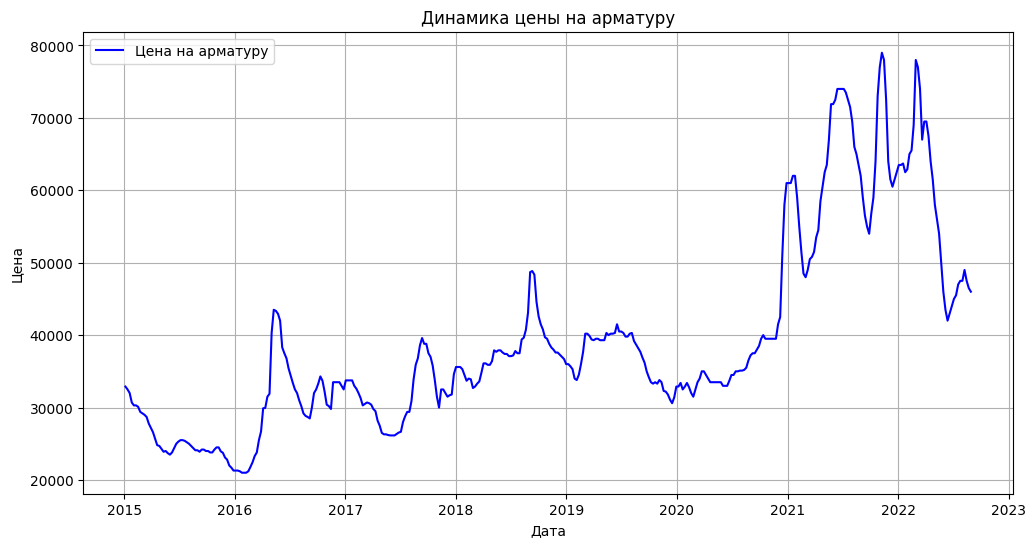

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Цена на арматуру"], label="Цена на арматуру", color="b")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Динамика цены на арматуру")
plt.legend()
plt.grid()
plt.show()

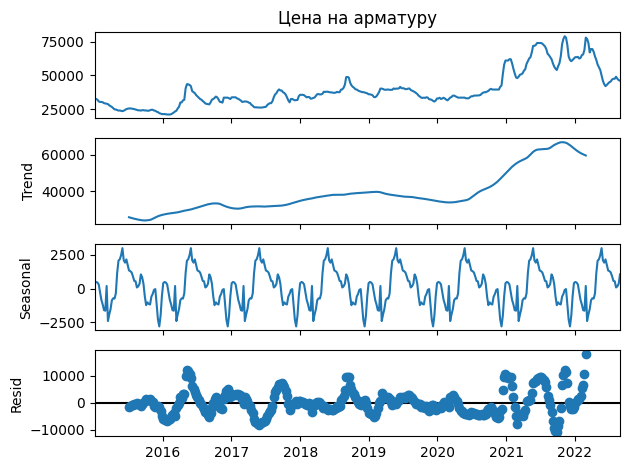

In [73]:
decomposition = seasonal_decompose(df["Цена на арматуру"], model="additive", period=52)
decomposition.plot()
plt.show()

In [74]:
df["lag_1"] = df["Цена на арматуру"].shift(1)
df["lag_2"] = df["Цена на арматуру"].shift(2)
df["lag_7"] = df["Цена на арматуру"].shift(7)
df["rolling_mean_7"] = df["Цена на арматуру"].rolling(window=7).mean()
df["year"] = df.index.year
df["month"] = df.index.month
df["week"] = df.index.isocalendar().week
df["day_of_week"] = df.index.dayofweek
df.dropna(inplace=True)

In [75]:
features = ["lag_1", "lag_2", "lag_7", "rolling_mean_7", "year", "month", "week", "day_of_week"]
target = "Цена на арматуру"
test_size = int(len(df) * 0.2)
X_train, y_train = df[features][:-test_size], df[target][:-test_size]
X_test, y_test = df[features][-test_size:], df[target][-test_size:]

In [76]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42, enable_categorical=False),
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=0.1)
}

results = {}
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }


c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.468e+08, tolerance: 1.688e+06
  model = cd_fast.enet_coordinate_descent(


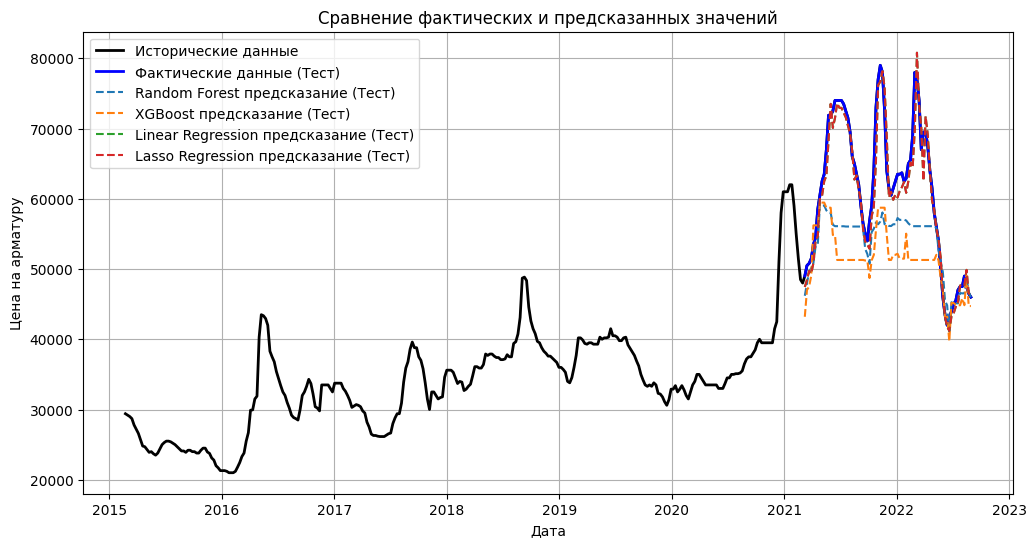

In [77]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df[target], label="Исторические данные", color="black", linewidth=2)
plt.plot(y_test.index, y_test, label="Фактические данные (Тест)", color="blue", linewidth=2)
for name, y_pred in predictions.items():
    plt.plot(y_test.index, y_pred, linestyle="dashed", label=f"{name} предсказание (Тест)")
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Сравнение фактических и предсказанных значений")
plt.legend()
plt.grid()
plt.show()

In [78]:
n_future = 30
future_dates = pd.date_range(start=df.index[-1], periods=n_future+1, freq="D")[1:]
future_df = pd.DataFrame(index=future_dates)
latest_data = df.iloc[-1][features]

for name, model in models.items():
    future_preds = []
    data_point = latest_data.copy()
    for _ in range(n_future):
        pred = model.predict([data_point])[0]
        future_preds.append(pred)
        data_point = np.roll(data_point, -1)
        data_point[-1] = pred
    future_df[name] = future_preds


c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\

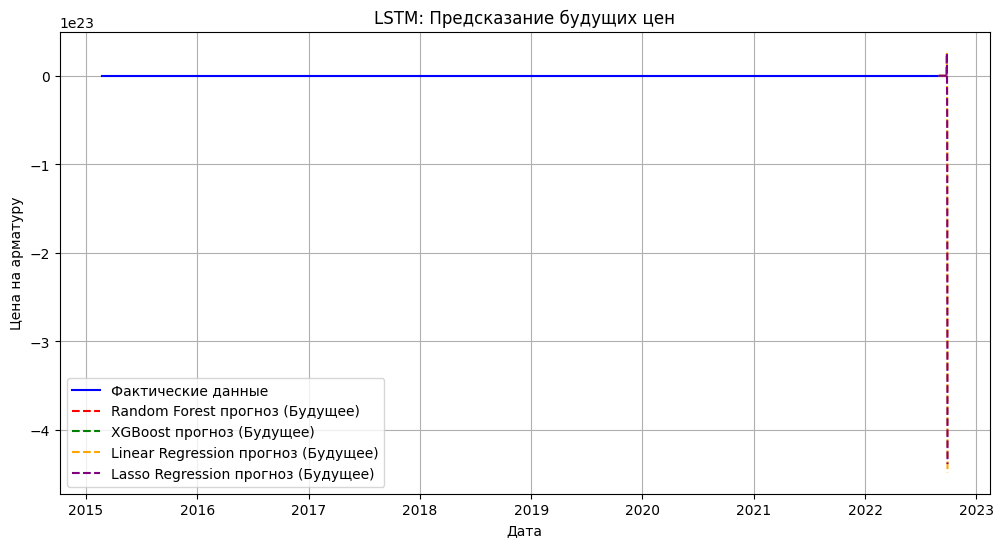

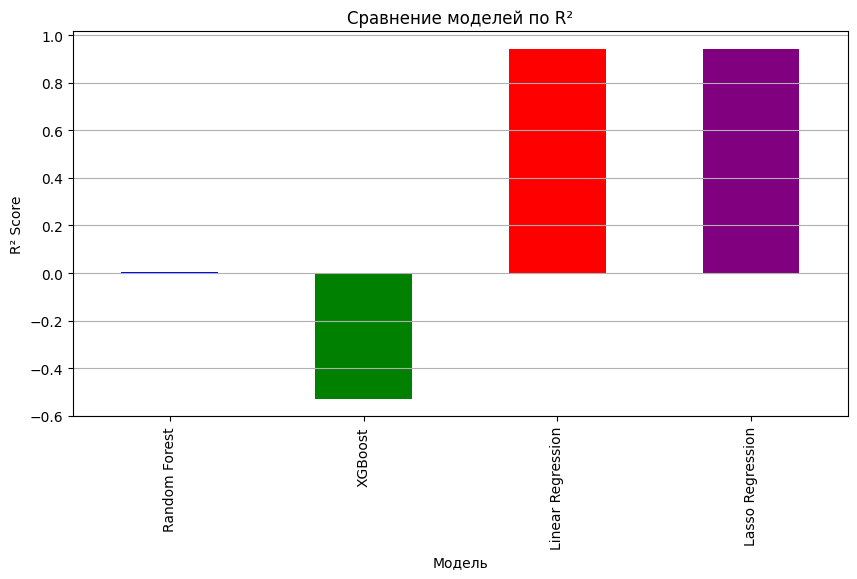

In [80]:
results_df = pd.DataFrame(results).T
plt.figure(figsize=(10, 5))
results_df["R2"].plot(kind="bar", color=["blue", "green", "red", "purple"])
plt.title("Сравнение моделей по R²")
plt.ylabel("R² Score")
plt.xlabel("Модель")
plt.grid(axis="y")
plt.show()


In [81]:
print(results_df)


                            MAE        R2
Random Forest       7748.179487  0.005957
XGBoost            10149.332031 -0.528926
Linear Regression   1776.405632  0.942352
Lasso Regression    1776.319757  0.942355
